ARIMA Description

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

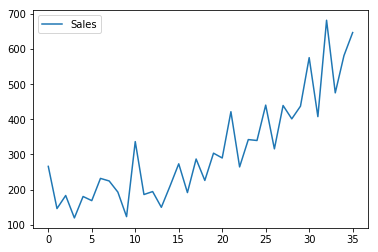

In [28]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api
from sklearn.metrics import mean_squared_error


data=pd.read_csv('datasets/shampoo.csv')
n = data.shape[0]
data.plot()

First We Need to Stationarize this model using Differencing Before selecting AR or MA parameters.
Using Augmented Dickey-Fuller to check Stationarity after Differencing

In [29]:
from statsmodels.tsa.stattools import adfuller

y = np.ravel(data['Sales'])
for d in range(11):
    y1 = np.diff(y, n=d)
    dftest = adfuller(y1, autolag='AIC')
    p_val = dftest[1]
    print("d= ", d, "p-val = ", p_val) 

d=  0 p-val =  1.0
d=  1 p-val =  1.7998574141687034e-10
d=  2 p-val =  0.0039063349396599245
d=  3 p-val =  1.2744787188241466e-05
d=  4 p-val =  0.7444311476892553
d=  5 p-val =  2.4551407127414807e-10
d=  6 p-val =  1.2873996638401125e-27
d=  7 p-val =  0.0
d=  8 p-val =  0.0
d=  9 p-val =  0.0
d=  10 p-val =  0.0


See that data is stationary for least differencing d=1.
Now testing the AR and MA parameters for ARIMA model

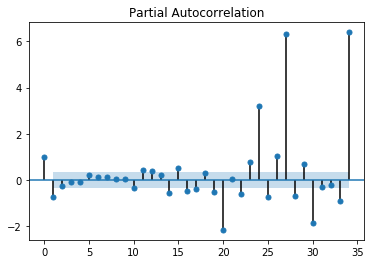

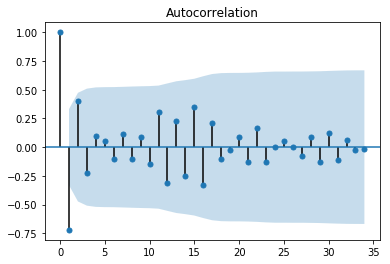

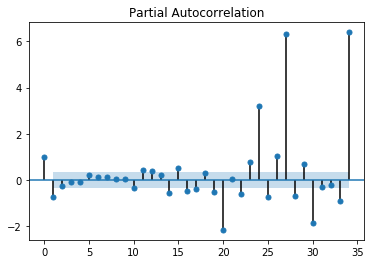

In [98]:
from statsmodels.graphics.tsaplots import *

yd = np.diff(y, n=1)
plot_acf(yd)
plot_pacf(yd)

If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.

If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.

As first lag is negative, and PACF cuts off after 1 lag, we take MA(1) model for first differenced array.


Fitting
Done
lag=  0
ARIMA RMSE =  77.09247228800626


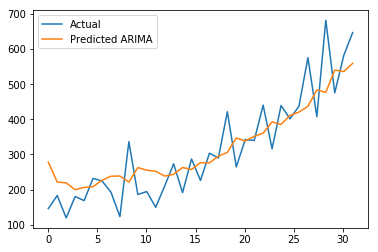

In [99]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=1
model = ARIMA(y, order=(p,d,q))

print("\nFitting")
model_fit = model.fit(transparams=True,trend='c', method='mle', maxiter=1000000)

#print(model_fit.summary())
print("Done")

lag = model_fit.k_ar
print("lag= ", lag)
ARIMA_pred = model_fit.predict(start=lag+d,end=n-1,dynamic=False, typ='levels')
ARIMA_actual = np.array([data["Sales"][i] for i in range(lag+d,n)])
ARIMA_rmse = sqrt(mean_squared_error(ARIMA_actual, ARIMA_pred))
print("ARIMA RMSE = ", ARIMA_rmse)

plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_actual, label="Actual")
plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_pred, label="Predicted ARIMA")

plt.legend()

As AR and MA can cancel each other, we try one more of one type with one less of other, and vice versa


Fitting
Done
lag=  1
ARIMA RMSE =  72.01697297723861


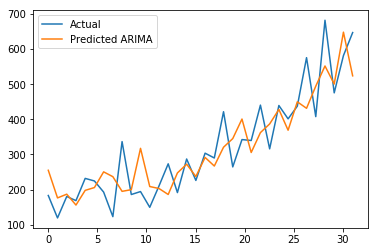

In [100]:
p=1
d=1
q=0
model = ARIMA(y, order=(p,d,q))

print("\nFitting")
model_fit = model.fit(transparams=True,trend='c', method='mle', maxiter=1000000)
#print(model_fit.summary())
print("Done")

lag = model_fit.k_ar
print("lag= ", lag)
ARIMA_pred = model_fit.predict(start=lag+d,end=n-1,dynamic=False, typ='levels')
ARIMA_actual = np.array([data["Sales"][i] for i in range(lag+d,n)])
ARIMA_rmse = sqrt(mean_squared_error(ARIMA_actual, ARIMA_pred))
print("ARIMA RMSE = ", ARIMA_rmse)

plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_actual, label="Actual")
plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_pred, label="Predicted ARIMA")

plt.legend()

Now, we attempt to automate the ARIMA hyperparameter search using Grid Search

In [101]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0,trend='c')
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = sqrt(mean_squared_error(test, predictions))
    return error

import warnings
warnings.filterwarnings("ignore")

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('\nBest ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [102]:
# load dataset
series = pd.read_csv('datasets/shampoo.csv', header=0, index_col=0, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.308
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=134.176
ARIMA(0, 1, 1) RMSE=97.767
ARIMA(0, 2, 0) RMSE=259.499
ARIMA(0, 2, 1) RMSE=135.360
ARIMA(1, 0, 0) RMSE=152.029
ARIMA(1, 1, 0) RMSE=84.388
ARIMA(1, 1, 1) RMSE=83.688
ARIMA(1, 2, 0) RMSE=136.411
ARIMA(2, 1, 0) RMSE=75.432
ARIMA(2, 1, 1) RMSE=88.089
ARIMA(2, 2, 0) RMSE=99.302
ARIMA(4, 1, 0) RMSE=81.545
ARIMA(4, 1, 1) RMSE=82.439
ARIMA(4, 2, 0) RMSE=87.157
ARIMA(4, 2, 1) RMSE=68.519
ARIMA(6, 1, 0) RMSE=82.523
ARIMA(6, 2, 0) RMSE=79.127
ARIMA(8, 1, 0) RMSE=81.115

Best ARIMA(4, 2, 1) RMSE=68.519


Fitting Reported Model and Plotting Result


Fitting
Done
lag=  4
ARIMA RMSE =  62.01700980202962


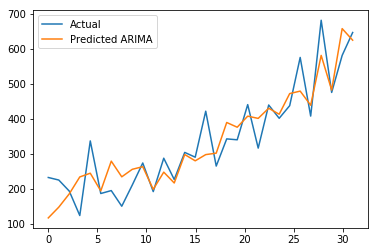

In [103]:
p=4
d=2
q=1
model = ARIMA(y, order=(p,d,q))

print("\nFitting")
model_fit = model.fit(transparams=True,trend='c', method='mle', maxiter=1000000)
#print(model_fit.summary())
print("Done")

lag = model_fit.k_ar
print("lag= ", lag)

ARIMA_pred = model_fit.predict(start=lag+d,end=n-1,dynamic=False, typ='levels')
ARIMA_actual = np.array([data["Sales"][i] for i in range(lag+d,n)])
ARIMA_rmse = sqrt(mean_squared_error(ARIMA_actual, ARIMA_pred))
print("ARIMA RMSE = ", ARIMA_rmse)

plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_actual, label="Actual")
plt.plot(np.linspace(0,31,len(ARIMA_actual)),ARIMA_pred, label="Predicted ARIMA")

plt.legend()

Visualizing Residuals

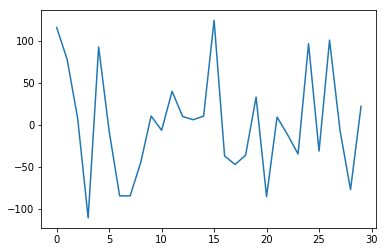

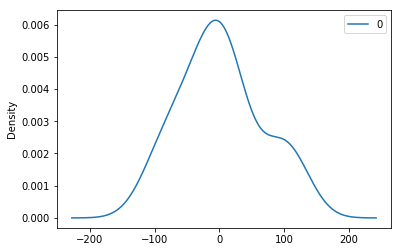

In [104]:
res = ARIMA_actual - ARIMA_pred
plt.plot(res)
pd.DataFrame(res).plot(kind='density')